## Some points to note

- The neo4j queries are explained in the previous notebooks. (under the notebooks directory in repo's root)
- Most of the code written is for checking dataframes in between, so very dirty at times and sub optimal too. (not the training part)
- The notebook was executed on google colab (there might be some formatting issues)
- neo4j instance ran on local machine and ngrok tool was used to expose it's tcp port over the internet for connection to colab (more info: [Stackoverflow](https://stackoverflow.com/questions/64579678/how-to-use-ngrok-to-expose-neo4j-instance-running-on-localhost-to-be-used-by-goo) )
- code might contain some unused imported libraries (most of the helper code was not uploaded for sanity). Please don't run the whole notebook, go one step at a time while reading instructions / comments
- parts of code need more documentation :)
- Citation dataset v11 is used for this task
- LDA is used and ten fields of study per author is taken to generate features

In [1]:
import gc

In [2]:
gc.collect()

20

In [1]:
from py2neo.data import Node, Relationship
import py2neo

In [2]:
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "graph"))

In [3]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.connector.neo4j import Neo4jGraphSAGENodeGenerator, Neo4jStellarGraph
from stellargraph.layer import GraphSAGE

import numpy as np
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import time
%matplotlib inline

In [4]:
# Authors
authors_df = graph.run(
    """
    MATCH (n:Author) RETURN n.name as name
    """).to_data_frame()

In [5]:
(authors_df.drop_duplicates() == authors_df).drop_duplicates()

,name
0,True


In [6]:
len(authors_df)

63800

In [7]:
authors_df.head()

,name
0,Eun-Kyeong Kwon
1,Yong-Gu Cho
2,Kijoon Chae
3,Dominik Slezak
4,Anthony Brabazon


In [8]:
# To give all the authors a identifier
dic_authors = {}
for i in range(len(authors_df)):
    dic_authors[authors_df['name'][i]] = i

In [9]:
len(dic_authors)

63800

In [10]:
authors_ = list(dic_authors.keys())
dic_authors[authors_[50]]

50

In [11]:
co = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_DIRECT]->(b) RETURN a.name as source,b.name as target 
    """).to_data_frame()

In [12]:
print(co.shape)
co.head()

(120775, 2)


,source,target
0,Eun-Kyeong Kwon,Kijoon Chae
1,Eun-Kyeong Kwon,Yong-Gu Cho
2,Yong-Gu Cho,Kijoon Chae
3,Kijoon Chae,Youngsoo Kim
4,Kijoon Chae,Yeojin Kim


In [13]:
co[co['source'] == 'Roel Peeters']

,source,target
101252,Roel Peeters,Christian Wachsmann
101253,Roel Peeters,Anthony Van Herrewege
101254,Roel Peeters,Milica Milutinovic
101255,Roel Peeters,Stefan Katzenbeisser


In [14]:
cal_colab_direct_df = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_DIRECT]->(b) RETURN a.name as source, b.name as target, r.collaborations
    """).to_data_frame()

In [15]:
print(cal_colab_direct_df.shape)
cal_colab_direct_df.head()

(120775, 3)


,source,target,r.collaborations
0,Eun-Kyeong Kwon,Kijoon Chae,2
1,Eun-Kyeong Kwon,Yong-Gu Cho,2
2,Yong-Gu Cho,Kijoon Chae,2
3,Kijoon Chae,Youngsoo Kim,1
4,Kijoon Chae,Yeojin Kim,1


In [16]:
ss = set()
for i in range(len(cal_colab_direct_df)):
    ss.add(cal_colab_direct_df['source'][i])
    ss.add(cal_colab_direct_df['target'][i])

In [17]:
len(ss)

60544

In [18]:
cal_colab_direct_df[cal_colab_direct_df['r.collaborations'] == 0]

,source,target,r.collaborations


In [19]:
# Calculate total collaborations per author (direct)
colab_dic_direct = {}
for i in range(len(cal_colab_direct_df)):
    if dic_authors[cal_colab_direct_df['source'][i]] not in colab_dic_direct.keys():
        colab_dic_direct[dic_authors[cal_colab_direct_df['source'][i]]] = cal_colab_direct_df['r.collaborations'][i]
    else:
        colab_dic_direct[dic_authors[cal_colab_direct_df['source'][i]]] += cal_colab_direct_df['r.collaborations'][i]

    if dic_authors[cal_colab_direct_df['target'][i]]  not in colab_dic_direct.keys():
        colab_dic_direct[dic_authors[cal_colab_direct_df['target'][i]]] = cal_colab_direct_df['r.collaborations'][i]
    else:
        colab_dic_direct[dic_authors[cal_colab_direct_df['target'][i]]] += cal_colab_direct_df['r.collaborations'][i]

In [20]:
print(len(colab_dic_direct))
# colab_dic_direct

60544


In [21]:
cal_colab_cited_df = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_CITED_FINAL]->(b) RETURN a.name as source, b.name as target, r.collaborations
    """).to_data_frame()

In [22]:
print(cal_colab_cited_df.shape)
cal_colab_cited_df.head()

(60863, 3)


,source,target,r.collaborations
0,Raymond W. Yeung,Amir F. Dana,2
1,Raymond W. Yeung,Simon R. Blackburn,2
2,Raymond W. Yeung,Andreas Winter,3
3,Raymond W. Yeung,Øyvind Ytrehus,2
4,Raymond W. Yeung,Sang-Woon Jeon,4


In [23]:
cal_colab_cited_df[cal_colab_cited_df['source'] == 'Steven Weber']

,source,target,r.collaborations
9802,Steven Weber,Amir K. Khandani,5
9803,Steven Weber,Chun-Hung Liu,3
9804,Steven Weber,Radhika Gowaikar,2
9805,Steven Weber,Giovanni Luca Torrisi,2
9806,Steven Weber,Junse Lee,2
9807,Steven Weber,Xiangying Yang,3
9808,Steven Weber,François Baccelli,2
9809,Steven Weber,Rahul Vaze,2
9810,Steven Weber,Gustavo de Veciana,2
9811,Steven Weber,Abolfazl S. Motahari,2


In [24]:
# Calculate total collaborations per author (cited)
colab_dic_cited = {}
for i in range(len(cal_colab_cited_df)):
    if dic_authors[cal_colab_cited_df['source'][i]] not in colab_dic_cited.keys():
        colab_dic_cited[dic_authors[cal_colab_cited_df['source'][i]]] = cal_colab_cited_df['r.collaborations'][i]
    else:
        colab_dic_cited[dic_authors[cal_colab_cited_df['source'][i]]] += cal_colab_cited_df['r.collaborations'][i]

    if dic_authors[cal_colab_cited_df['target'][i]]  not in colab_dic_cited.keys():
        colab_dic_cited[dic_authors[cal_colab_cited_df['target'][i]]] = cal_colab_cited_df['r.collaborations'][i]
    else:
        colab_dic_cited[dic_authors[cal_colab_cited_df['target'][i]]] += cal_colab_cited_df['r.collaborations'][i]

In [25]:
print(len(colab_dic_cited))
# colab_dic_direct

8868


In [26]:
colab_dic_direct == colab_dic_cited

False

In [27]:
co['source'] = co['source'].apply(lambda x: dic_authors[x])
co['target'] = co['target'].apply(lambda x: dic_authors[x])

In [28]:
co.head()
dff = co
del co

In [29]:
print(dff.shape)
dff.head()

(120775, 2)


,source,target
0,0,2
1,0,1
2,1,2
3,2,50962
4,2,59629


In [30]:
dff['target'].max()

63799

In [31]:
# cora_feature_names = [f"f{i}" for i in range(2)]
# print(cora_feature_names)

['f0', 'f1']


In [32]:
cols = ['dir_colabs', 'cited_colabs']
idx = [i for i in range(len(dic_authors))]

In [33]:
feat = pd.DataFrame(index=idx, columns=cols)

In [34]:
feat.fillna(0, inplace=True)
feat.head()

,dir_colabs,cited_colabs
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [35]:
for i in range(len(dic_authors)):
    if i in colab_dic_direct.keys():
        feat['dir_colabs'][i] = colab_dic_direct[i]
    else:
        feat['dir_colabs'][i] = 0
        
    if i in colab_dic_cited.keys():
        feat['cited_colabs'][i] = colab_dic_cited[i]
    else:
        feat['cited_colabs'][i] = 0

feat.head()

,dir_colabs,cited_colabs
0,4,0
1,4,0
2,16,0
3,19,0
4,15,0


In [36]:
len(feat['cited_colabs'].drop_duplicates())

489

In [37]:
# Normalise thee feaatures to feed into the moddel
dir_mean = feat['dir_colabs'].mean()
dir_max = feat['dir_colabs'].max()
dir_min = feat['dir_colabs'].min()

cit_mean = feat['cited_colabs'].mean()
cit_max = feat['cited_colabs'].max()
cit_min = feat['cited_colabs'].min()

In [38]:
feat['dir_colabs'] = feat['dir_colabs'].apply(lambda x: ((x - dir_min) / (dir_max - dir_min)))
feat['cited_colabs'] = feat['cited_colabs'].apply(lambda x: ((x - cit_min) / (cit_max - cit_min)))

In [39]:
feat.head(10)

,dir_colabs,cited_colabs
0,0.016667,0.0
1,0.016667,0.0
2,0.066667,0.0
3,0.079167,0.0
4,0.062500,0.0
5,0.016667,0.0
6,0.004167,0.0
7,0.041667,0.0
8,0.016667,0.0
9,0.054167,0.0


In [40]:
from tqdm import tqdm
tqdm.pandas()

In [41]:
fos_dff = graph.run("""

MATCH((n:Author)<-[:AUTHOR]-(a:Article))
RETURN n.name as name,apoc.text.join(collect(a.fos),":") as fos,apoc.text.join(collect(a.title)," ") as title
ORDER BY n.name

""").to_data_frame()

In [42]:
fos_dff.head(5)

,name,fos,title
0,A Aart Blokhuis,Discrete mathematics:0.4204095:Combinatorics:0...,Bounds for the size of radar arrays
1,A Alejandro Montes Garcia,Empirical research:0.471031338:Cluster analysi...,Effects of Evolutionary Linguistics in Text Cl...
2,A Anne Rozinat,Versa:0.441023469:Business process:0.4714488:T...,Conformance testing : Measuring the fit and ap...
3,A Arakala,Biometrics:0.4345782:Minutiae:0.700131357:Fing...,Fuzzy extractors for minutiae-based fingerprin...
4,A Campilho,Image segmentation:0.619028568:Discrete mathem...,Automatic image segmentation using a deformabl...


In [43]:
def get_d(x):
    t = x.split(':')
    dict_val={}
    for i in range(len(t)):
        try:
            if(float(t[i])):
                if(t[i-1] in dict_val):
                    dict_val[t[i-1]].append(t[i])
                else:
                    dict_val[t[i-1]]=[t[i]]
        except:
            pass
    for i in dict_val:
        dict_val[i] = sorted(dict_val[i],reverse=True)
    return dict_val

In [44]:
fos_dff['key'] = fos_dff['fos'].apply(lambda x: get_d(x))

In [45]:
fos_dff.head(10)

,name,fos,title,key
0,A Aart Blokhuis,Discrete mathematics:0.4204095:Combinatorics:0...,Bounds for the size of radar arrays,"{'Discrete mathematics': ['0.4204095'], 'Combi..."
1,A Alejandro Montes Garcia,Empirical research:0.471031338:Cluster analysi...,Effects of Evolutionary Linguistics in Text Cl...,"{'Empirical research': ['0.471031338'], 'Clust..."
2,A Anne Rozinat,Versa:0.441023469:Business process:0.4714488:T...,Conformance testing : Measuring the fit and ap...,"{'Versa': ['0.441023469'], 'Business process':..."
3,A Arakala,Biometrics:0.4345782:Minutiae:0.700131357:Fing...,Fuzzy extractors for minutiae-based fingerprin...,"{'Biometrics': ['0.4345782'], 'Minutiae': ['0...."
4,A Campilho,Image segmentation:0.619028568:Discrete mathem...,Automatic image segmentation using a deformabl...,"{'Image segmentation': ['0.619028568'], 'Discr..."
5,A Hammers,Mutual information:0.406580359:Image segmentat...,Construction and validation of mean shape atla...,"{'Mutual information': ['0.406580359'], 'Image..."
6,A Jakoby,Computational physics:0.4558729:Discrete mathe...,A parallel semi-implicit method for 3D nonline...,"{'Computational physics': ['0.4558729'], 'Disc..."
7,A Kaptein,Computer engineering:0.460699946:Electronic pr...,A model-based approach providing context-sensi...,"{'Computer engineering': ['0.460699946'], 'Ele..."
8,A Leonardis,Image restoration:0.484874457:Initialization:0...,A Physically-Motivated Deformable Model Based ...,"{'Image restoration': ['0.484874457'], 'Initia..."
9,A Min Tjoa,Knowledge management:0.457342237:Personalizati...,Towards the use of ontologies for improving us...,"{'Knowledge management': ['0.457342237'], 'Per..."


In [46]:
fos_dff['key'] = fos_dff['key'].apply(lambda x: {k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)} )

In [47]:
def get_ten(x):
    y={}
    k=list(x.keys())[:10]
    for i in k:
        y[i]=x[i]    
    return y

fos_dff['sortedkey'] = fos_dff['key'].apply(lambda x:get_ten(x))

In [48]:
fos_dff.head(10)

,name,fos,title,key,sortedkey
0,A Aart Blokhuis,Discrete mathematics:0.4204095:Combinatorics:0...,Bounds for the size of radar arrays,"{'Matrix (mathematics)': ['0.4815577'], 'Radar...","{'Matrix (mathematics)': ['0.4815577'], 'Radar..."
1,A Alejandro Montes Garcia,Empirical research:0.471031338:Cluster analysi...,Effects of Evolutionary Linguistics in Text Cl...,"{'Cluster analysis': ['0.547445059'], 'Evoluti...","{'Cluster analysis': ['0.547445059'], 'Evoluti..."
2,A Anne Rozinat,Versa:0.441023469:Business process:0.4714488:T...,Conformance testing : Measuring the fit and ap...,"{'Transaction log': ['0.555015'], 'Conformance...","{'Transaction log': ['0.555015'], 'Conformance..."
3,A Arakala,Biometrics:0.4345782:Minutiae:0.700131357:Fing...,Fuzzy extractors for minutiae-based fingerprin...,"{'Minutiae': ['0.700131357'], 'Fingerprint rec...","{'Minutiae': ['0.700131357'], 'Fingerprint rec..."
4,A Campilho,Image segmentation:0.619028568:Discrete mathem...,Automatic image segmentation using a deformabl...,"{'Image segmentation': ['0.619028568'], 'Class...","{'Image segmentation': ['0.619028568'], 'Class..."
5,A Hammers,Mutual information:0.406580359:Image segmentat...,Construction and validation of mean shape atla...,"{'Image segmentation': ['0.601378739'], 'Compu...","{'Image segmentation': ['0.601378739'], 'Compu..."
6,A Jakoby,Computational physics:0.4558729:Discrete mathe...,A parallel semi-implicit method for 3D nonline...,{'Computational magnetohydrodynamics': ['0.684...,{'Computational magnetohydrodynamics': ['0.684...
7,A Kaptein,Computer engineering:0.460699946:Electronic pr...,A model-based approach providing context-sensi...,"{'Electronic program guide': ['0.55619055'], '...","{'Electronic program guide': ['0.55619055'], '..."
8,A Leonardis,Image restoration:0.484874457:Initialization:0...,A Physically-Motivated Deformable Model Based ...,"{'Watershed': ['0.5677321'], 'Image segmentati...","{'Watershed': ['0.5677321'], 'Image segmentati..."
9,A Min Tjoa,Knowledge management:0.457342237:Personalizati...,Towards the use of ontologies for improving us...,"{'Efficient XML Interchange': ['0.716740966'],...","{'Efficient XML Interchange': ['0.716740966'],..."


In [49]:
fos_dff['sortedkey'][0].keys()

dict_keys(['Matrix (mathematics)', 'Radar', 'Inequality', 'Combinatorics', 'Discrete mathematics', 'Mathematics'])

In [50]:
kk = set()
for i in range(len(fos_dff)):
    for k in fos_dff['sortedkey'][i].keys():
        kk.add(k)

In [51]:
len(kk)

17506

In [52]:
kkk = list()
for i in range(len(fos_dff)):
    for k in fos_dff['sortedkey'][i].keys():
        kkk.append(k)

In [53]:
print(len(kkk))
print(len(set(kkk)))

587864
17506


In [54]:
fos_dff['FOS_BEST'] = fos_dff['sortedkey'].apply(lambda x: list(x.keys()))

In [55]:
print(fos_dff['FOS_BEST'][0])
print(fos_dff['FOS_BEST'][63798])

['Matrix (mathematics)', 'Radar', 'Inequality', 'Combinatorics', 'Discrete mathematics', 'Mathematics']
['Pattern matching', 'Subsequence', 'Gram', 'Theoretical computer science', 'Discrete mathematics', 'Computer science']


In [56]:
# Practice
fos_dff['FOS_BEST']

0        [Matrix (mathematics), Radar, Inequality, Comb...
1        [Cluster analysis, Evolutionary linguistics, E...
2        [Transaction log, Conformance testing, Referen...
3        [Minutiae, Fingerprint recognition, Authentica...
4        [Image segmentation, Classical electromagnetis...
                               ...                        
63795    [Pattern matching, Subsequence, Gram, Theoreti...
63796    [Delimiter, HTML, XML, Markup language, Natura...
63797    [Learning environment, Synchronous learning, E...
63798    [Pattern matching, Subsequence, Gram, Theoreti...
63799    [Distributed computing, Computer science, Spec...
Name: FOS_BEST, Length: 63800, dtype: object

In [57]:
fos_multi_list = []
for i in range(len(fos_dff)):
  fos_multi_list.append(fos_dff['FOS_BEST'][i])

print(len(fos_multi_list))

63800


In [58]:
print(fos_multi_list[10])

['Watershed', 'Image segmentation', 'Image processing', 'Image restoration', 'Fluid dynamics', 'Mathematical morphology', 'Partial differential equation', 'Computer vision', 'Initialization', 'Computer science']


In [ ]:
print(kk)

In [ ]:
fos_list = list(kk)
print(fos_list)

### LDA used here, the part to train the LDA model has been commented and the saved model is loaded. Use accordingly

In [61]:
# LDA Logic ahead
import pandas as pd
import numpy as np

import re
import string

import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

d:\env\env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [62]:
dictionary = corpora.Dictionary(fos_multi_list)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in fos_multi_list]

In [63]:
# logging
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [64]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamulticore.LdaMulticore

# Build LDA model
# lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=80, random_state=100, passes=50,iterations=100)
lda_model = gensim.models.ldamodel.LdaModel.load(r"D:\notebooks\lp\lda\model\lda_model.model")

2021-04-21 00:02:05,459 : INFO : loading LdaModel object from D:\notebooks\lp\lda\model\lda_model.model
2021-04-21 00:02:05,462 : INFO : loading expElogbeta from D:\notebooks\lp\lda\model\lda_model.model.expElogbeta.npy with mmap=None
2021-04-21 00:02:05,474 : INFO : setting ignored attribute dispatcher to None
2021-04-21 00:02:05,475 : INFO : setting ignored attribute id2word to None
2021-04-21 00:02:05,476 : INFO : setting ignored attribute state to None
2021-04-21 00:02:05,477 : INFO : LdaMulticore lifecycle event {'fname': 'D:\\notebooks\\lp\\lda\\model\\lda_model.model', 'datetime': '2021-04-21T00:02:05.477316', 'gensim': '4.0.1', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.18362-SP0', 'event': 'loaded'}
2021-04-21 00:02:05,478 : INFO : loading LdaState object from D:\notebooks\lp\lda\model\lda_model.model.state
2021-04-21 00:02:05,488 : INFO : LdaState lifecycle event {'fname': 'D:\\notebooks\\lp\\lda\\m

In [65]:
print(lda_model.get_term_topics('Computer science'))

[(0, 0.028158896), (1, 0.040708113), (3, 0.17056112), (4, 0.1798237), (5, 0.037887566), (6, 0.013244342), (7, 0.023258457), (9, 0.06192701), (11, 0.022470525), (14, 0.028821277), (16, 0.08706847), (18, 0.04059214), (19, 0.03604385), (21, 0.11183), (27, 0.17696337), (28, 0.02876005), (29, 0.06822182), (30, 0.09487047), (31, 0.043318216), (32, 0.07206491), (35, 0.06251461), (37, 0.09991048), (38, 0.10810062), (39, 0.07220449), (42, 0.022579134), (43, 0.03341099), (44, 0.047455188), (45, 0.10439112), (47, 0.07495602), (48, 0.012446683), (51, 0.012872744), (53, 0.012565144), (54, 0.011239795), (56, 0.12525532), (57, 0.0117244), (58, 0.07028545), (59, 0.024616295), (60, 0.056122687), (63, 0.016313113), (65, 0.015773227), (68, 0.052301068), (69, 0.0873502), (70, 0.042898532), (72, 0.10608263), (73, 0.033564553), (74, 0.11042948), (75, 0.021631734), (76, 0.027278643), (78, 0.05796712), (83, 0.030996077), (84, 0.024341611), (85, 0.09696724), (86, 0.11940768), (89, 0.016423795), (90, 0.05089914

In [66]:
new_topics = lda_model.print_topics(124)

2021-04-21 00:02:05,515 : INFO : topic #0 (0.008): 0.476*"Architecture" + 0.160*"Systems architecture" + 0.062*"Distributed computing" + 0.053*"Internet Protocol" + 0.049*"Information integration" + 0.028*"Computer science" + 0.025*"Image resolution" + 0.022*"Packet switching" + 0.020*"Code generation" + 0.018*"Complete information"
2021-04-21 00:02:05,517 : INFO : topic #1 (0.008): 0.166*"Integer" + 0.148*"Heuristic" + 0.086*"Workload" + 0.070*"Adaptive system" + 0.043*"Automatic summarization" + 0.041*"Computer science" + 0.040*"Tuple" + 0.030*"Enumeration" + 0.029*"Hadamard transform" + 0.025*"Roaming"
2021-04-21 00:02:05,518 : INFO : topic #2 (0.008): 0.066*"Phenomenon" + 0.065*"Web server" + 0.041*"Quantum convolutional code" + 0.041*"Quantum computer" + 0.037*"Multi-objective optimization" + 0.036*"Flow network" + 0.034*"Quantum algorithm" + 0.031*"Robot control" + 0.030*"Markov decision process" + 0.029*"Quantum information"
2021-04-21 00:02:05,519 : INFO : topic #3 (0.008): 0.1

2021-04-21 00:02:05,553 : INFO : topic #25 (0.008): 0.190*"Matrix (mathematics)" + 0.098*"Programming language" + 0.091*"Additive white Gaussian noise" + 0.060*"Gaussian noise" + 0.049*"Compressed sensing" + 0.046*"Sparse matrix" + 0.042*"Sparse approximation" + 0.042*"White noise" + 0.038*"Particle swarm optimization" + 0.030*"Modulation"
2021-04-21 00:02:05,554 : INFO : topic #26 (0.008): 0.132*"Asynchronous communication" + 0.079*"Probability density function" + 0.070*"Rate–distortion theory" + 0.058*"Rayleigh fading" + 0.045*"Fading distribution" + 0.044*"Automation" + 0.041*"Planar graph" + 0.037*"Analogy" + 0.036*"Convex hull" + 0.031*"Piecewise"
2021-04-21 00:02:05,555 : INFO : topic #27 (0.008): 0.375*"Theoretical computer science" + 0.177*"Computer science" + 0.113*"Distributed computing" + 0.073*"Discrete mathematics" + 0.050*"Interoperability" + 0.049*"Tornado code" + 0.031*"State space" + 0.017*"Process control" + 0.011*"Burst error-correcting code" + 0.009*"Variable-order 

2021-04-21 00:02:05,579 : INFO : topic #50 (0.008): 0.159*"Multicast" + 0.075*"Xcast" + 0.063*"Source-specific multicast" + 0.061*"Protocol Independent Multicast" + 0.057*"Pragmatic General Multicast" + 0.053*"Distributed computing" + 0.050*"Finite element method" + 0.050*"Distance Vector Multicast Routing Protocol" + 0.048*"Computer network" + 0.042*"IP multicast"
2021-04-21 00:02:05,580 : INFO : topic #51 (0.008): 0.228*"Feature vector" + 0.061*"Binary erasure channel" + 0.060*"Naive Bayes classifier" + 0.053*"Abstract machine" + 0.043*"Data processing" + 0.033*"Routing table" + 0.031*"Shannon–Hartley theorem" + 0.026*"Domain-specific language" + 0.025*"IPv6" + 0.025*"Abstract state machines"
2021-04-21 00:02:05,581 : INFO : topic #52 (0.008): 0.087*"Sampling (statistics)" + 0.070*"Database design" + 0.066*"Randomized algorithm" + 0.060*"Feature (computer vision)" + 0.055*"Shared resource" + 0.050*"Time delay neural network" + 0.044*"View" + 0.040*"Database schema" + 0.038*"Abstracti

2021-04-21 00:02:05,600 : INFO : topic #74 (0.008): 0.152*"Telecommunications network" + 0.115*"Distributed computing" + 0.111*"Implementation" + 0.111*"Computer science" + 0.075*"Wireless" + 0.042*"Complementary sequences" + 0.041*"Computer network" + 0.037*"Multiplexing" + 0.033*"Data collection" + 0.026*"Experimental data"
2021-04-21 00:02:05,600 : INFO : topic #75 (0.008): 0.115*"Turbo code" + 0.089*"Iterative reconstruction" + 0.079*"String (computer science)" + 0.069*"Reed–Solomon error correction" + 0.054*"Computer graphics (images)" + 0.053*"Web navigation" + 0.047*"User modeling" + 0.034*"Space–time trellis code" + 0.030*"String searching algorithm" + 0.028*"3D reconstruction"
2021-04-21 00:02:05,601 : INFO : topic #76 (0.008): 0.128*"Network topology" + 0.116*"Personalization" + 0.052*"Recommender system" + 0.052*"Empirical research" + 0.051*"Network congestion" + 0.050*"Fourier transform" + 0.048*"Functional analysis" + 0.034*"BCJR algorithm" + 0.031*"Mobility model" + 0.030

2021-04-21 00:02:05,619 : INFO : topic #99 (0.008): 0.252*"Mobile computing" + 0.207*"Mobile agent" + 0.086*"Distributed computing" + 0.057*"Mobile search" + 0.056*"Computer science" + 0.036*"Mobile Web" + 0.033*"Abstract interpretation" + 0.029*"Mobile station" + 0.026*"Rule-based machine translation" + 0.024*"Mobile technology"
2021-04-21 00:02:05,620 : INFO : topic #100 (0.008): 0.266*"Web service" + 0.068*"Service provider" + 0.047*"Service delivery framework" + 0.047*"Services computing" + 0.044*"Service-oriented architecture" + 0.040*"Distributed computing" + 0.039*"Service discovery" + 0.038*"Differentiated service" + 0.038*"Visual Word" + 0.033*"Conceptual model"
2021-04-21 00:02:05,621 : INFO : topic #101 (0.008): 0.223*"Middleware" + 0.133*"Complex system" + 0.093*"Software development process" + 0.077*"Reuse" + 0.060*"Programming paradigm" + 0.055*"Distributed computing" + 0.046*"Executable" + 0.044*"Steganography" + 0.035*"Data flow diagram" + 0.031*"Local area network"
202

In [ ]:
print(new_topics)

In [68]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5      0.369621 -0.265119       1        1  3.079266
3     -0.109352 -0.093316       2        1  2.368365
96     0.538535 -0.139561       3        1  2.348470
4     -0.034749 -0.313109       4        1  2.304689
27    -0.148451  0.039990       5        1  1.514441
...         ...       ...     ...      ...       ...
67     0.038904  0.480535     116        1  0.477486
63     0.121241  0.378577     117        1  0.460818
111    0.468510  0.162023     118        1  0.454217
42     0.055532  0.356774     119        1  0.447084
44     0.194186 -0.058516     120        1  0.389435

[120 rows x 5 columns], topic_info=                       Term          Freq         Total  Category  logprob  \
1      Discrete mathematics  11119.000000  11119.000000   Default  30.0000   
3               Mathematics   5823.000000   5823.000000   Default  29.0000   
7          Computer science  29125.000000  29125.000000   Default  28.0000   
239            Architecture   3998.000000   3998.000000   Default  27.0000   
32          Computer vision   3959.000000   3959.000000   Default  26.0000   
...                     ...           ...           ...       ...      ...   
6357       Information good      8.543854      9.706270  Topic120  -5.5908   
8633                 Honour      7.012627      8.175043  Topic120  -5.7883   
3071  Wireless mesh network     15.662001     63.458974  Topic120  -4.9848   
7          Computer science    109.218151  29125.763178  Topic120  -3.0427   
46    Distributed computing     60.666830  18539.085698  Topic120  -3.6306   

      loglift  
1     30.0000  
3     29.0000  
7     28.0000  
239   27.0000  
32    26.0000  
...       ...  
6357   5.4207  
8633   5.3949  
3071   4.1491  
7     -0.0378  
46    -0.1740  

[4082 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
4139    112  0.994096          1-planar graph
3700     26  0.931765                   2-opt
2422     87  0.987041  3-dimensional matching
712      59  0.992984       3D reconstruction
1973     92  0.976629                 3G MIMO
...     ...       ...                     ...
1698    108  0.978118                    sort
8052     27  0.726779                  splice
5281     97  0.988795                strictfp
8152     63  0.958086                  tf–idf
4382     71  0.991363             ω-automaton

[3933 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 97, 5, 28, 59, 1, 107, 31, 57, 30, 119, 78, 113, 10, 13, 39, 114, 116, 33, 48, 87, 101, 26, 94, 7, 46, 95, 29, 96, 111, 108, 93, 109, 56, 54, 12, 61, 70, 51, 100, 73, 83, 20, 37, 19, 105, 75, 85, 32, 50, 14, 102, 16, 44, 65, 98, 120, 76, 79, 69, 22, 15, 99, 24, 74, 63, 86, 104, 88, 67, 9, 17, 71, 110, 11, 49, 66, 3, 25, 90, 106, 84, 91, 77, 38, 118, 115, 55, 58, 18, 21, 89, 42, 72, 23, 8, 41, 92, 117, 62, 40, 27, 82, 60, 2, 81, 34, 80, 103, 52, 47, 53, 36, 35, 68, 64, 112, 43, 45])

In [69]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=fos_multi_list, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2021-04-21 00:06:21,559 : INFO : -26.711 per-word bound, 109839884.9 perplexity estimate based on a held-out corpus of 63800 documents with 587864 words
2021-04-21 00:06:21,610 : INFO : using ParallelWordOccurrenceAccumulator(processes=19, batch_size=64) to estimate probabilities from sliding windows



Perplexity:  -26.71082677744713


2021-04-21 00:06:36,871 : INFO : 19 accumulators retrieved from output queue
2021-04-21 00:06:42,611 : INFO : accumulated word occurrence stats for 63268 virtual documents



Coherence Score:  0.5069075106918339


In [71]:
# lda_model.save("models/lda_model.model")

2021-04-20 19:16:49,684 : INFO : LdaState lifecycle event {'fname_or_handle': 'models/lda_model.model.state', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-04-20T19:16:49.684136', 'gensim': '4.0.1', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.18362-SP0', 'event': 'saving'}
2021-04-20 19:16:49,707 : INFO : saved models/lda_model.model.state
2021-04-20 19:16:49,724 : INFO : LdaMulticore lifecycle event {'fname_or_handle': 'models/lda_model.model', 'separately': "['expElogbeta', 'sstats']", 'sep_limit': 10485760, 'ignore': ['id2word', 'state', 'dispatcher'], 'datetime': '2021-04-20T19:16:49.724026', 'gensim': '4.0.1', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.18362-SP0', 'event': 'saving'}
2021-04-20 19:16:49,726 : INFO : storing np array 'expElogbeta' to models/lda_model.model.expElogbeta.npy
20

In [ ]:
# lda_model = gensim.models.ldamodel.LdaModel.load("/content/gdrive/MyDrive/GraphSAGE_Ndarrays/LDA/model/lda_model.model")

In [63]:
from gensim.models.coherencemodel import CoherenceModel

d:\env\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
  def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

d:\env\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=fos_multi_list, start=50, limit=200, step=5)

d:\env\env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
# len(fos_multi_list)

527402

In [79]:
# cout = 0
# for i in range(len(fos_multi_list)):
#     for ele in fos_multi_list[i]:
#         if len(ele) > 0:
#             cout += 1
# print(cout)

4633703


In [70]:
fos_multi_list[0]

['Matrix (mathematics)',
 'Radar',
 'Inequality',
 'Combinatorics',
 'Discrete mathematics',
 'Mathematics']

In [71]:
topic_set = set()
topic_list = list()

for i in range(len(fos_multi_list)):
  for j in range(len(fos_multi_list[i])):
    topic_probs = lda_model.get_term_topics(fos_multi_list[i][j])
    ctr = 0
    for (a, b) in topic_probs:
      ctr += 1
      if ctr > 25:
        break
      topic_set.add(str(a))    
  topic_list.append(tuple(topic_set))
  topic_set.clear()



In [72]:
len(topic_list[500])

6

In [73]:
topic_list[0]

('77', '96', '115', '12', '118', '27', '5', '25')

In [74]:
sum = 0
for i in range(len(fos_multi_list)):
  sum += len(fos_multi_list[i])

print(sum / len(fos_multi_list))

9.214169278996865


In [75]:
sum = 0
for i in range(len(topic_list)):
  sum += len(topic_list[i])

print(sum / len(topic_list))

20.293291536050155


### Generate the reduced ote feature mat (done after topic modelling for field of studies)

In [76]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [77]:
# for topic list tuple
s = topic_list
s = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=fos_dff.index)

In [78]:
s

,0,1,10,100,101,102,103,104,105,106,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63795,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
63796,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63797,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
63798,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [79]:
fos_dff.head()

,name,fos,title,key,sortedkey,FOS_BEST
0,A Aart Blokhuis,Discrete mathematics:0.4204095:Combinatorics:0...,Bounds for the size of radar arrays,"{'Matrix (mathematics)': ['0.4815577'], 'Radar...","{'Matrix (mathematics)': ['0.4815577'], 'Radar...","[Matrix (mathematics), Radar, Inequality, Comb..."
1,A Alejandro Montes Garcia,Empirical research:0.471031338:Cluster analysi...,Effects of Evolutionary Linguistics in Text Cl...,"{'Cluster analysis': ['0.547445059'], 'Evoluti...","{'Cluster analysis': ['0.547445059'], 'Evoluti...","[Cluster analysis, Evolutionary linguistics, E..."
2,A Anne Rozinat,Versa:0.441023469:Business process:0.4714488:T...,Conformance testing : Measuring the fit and ap...,"{'Transaction log': ['0.555015'], 'Conformance...","{'Transaction log': ['0.555015'], 'Conformance...","[Transaction log, Conformance testing, Referen..."
3,A Arakala,Biometrics:0.4345782:Minutiae:0.700131357:Fing...,Fuzzy extractors for minutiae-based fingerprin...,"{'Minutiae': ['0.700131357'], 'Fingerprint rec...","{'Minutiae': ['0.700131357'], 'Fingerprint rec...","[Minutiae, Fingerprint recognition, Authentica..."
4,A Campilho,Image segmentation:0.619028568:Discrete mathem...,Automatic image segmentation using a deformabl...,"{'Image segmentation': ['0.619028568'], 'Class...","{'Image segmentation': ['0.619028568'], 'Class...","[Image segmentation, Classical electromagnetis..."


In [80]:
fos_dff.drop(columns=["fos", "title", "key", "sortedkey", "FOS_BEST"], axis=1, inplace=True)
fos_dff.head()

,name
0,A Aart Blokhuis
1,A Alejandro Montes Garcia
2,A Anne Rozinat
3,A Arakala
4,A Campilho


In [81]:
horizontal_feature = pd.concat([fos_dff, s], axis=1)

In [82]:
horizontal_feature.head(10)

,name,0,1,10,100,101,102,103,104,105,...,90,91,92,93,94,95,96,97,98,99
0,A Aart Blokhuis,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,A Alejandro Montes Garcia,1,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,A Anne Rozinat,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,A Arakala,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A Campilho,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
5,A Hammers,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,A Jakoby,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
7,A Kaptein,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,A Leonardis,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9,A Min Tjoa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
horizontal_feature.shape

(63800, 121)

In [84]:
import gc

In [85]:
del fos_dff
del s
gc.collect()

45

In [86]:
horizontal_feature['name'] = horizontal_feature['name'].apply(lambda x: dic_authors[x])

In [87]:
horizontal_feature.head()

,name,0,1,10,100,101,102,103,104,105,...,90,91,92,93,94,95,96,97,98,99
0,26121,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,34806,1,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,35266,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,3338,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,61889,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [88]:
# Add features from feat df
cited_colab_feat = pd.DataFrame()
cited_colab_feat['cited_colabs'] = feat['cited_colabs']
horizontal_feature['cited_colabs'] = feat['cited_colabs']
for i in tqdm(range(len(horizontal_feature))):
  cited_colab_feat['cited_colabs'][i] = feat['cited_colabs'][horizontal_feature['name'][i]]

horizontal_feature['cited_colabs'] = cited_colab_feat['cited_colabs']
len(horizontal_feature['cited_colabs'].drop_duplicates())

100%|█████████████████████████████████████████████████████████████████████████| 63800/63800 [00:04<00:00, 15252.83it/s]


489

In [89]:
# Add features from feat df
dir_colab_feat = pd.DataFrame()
dir_colab_feat['dir_colabs'] = feat['dir_colabs']
horizontal_feature['dir_colabs'] = feat['dir_colabs']
for i in tqdm(range(len(horizontal_feature))):
  dir_colab_feat['dir_colabs'][i] = feat['dir_colabs'][horizontal_feature['name'][i]]

horizontal_feature['dir_colabs'] = dir_colab_feat['dir_colabs']
len(horizontal_feature['dir_colabs'].drop_duplicates())

100%|█████████████████████████████████████████████████████████████████████████| 63800/63800 [00:03<00:00, 15964.63it/s]


108

In [90]:
horizontal_feature.set_index("name", inplace=True)

In [91]:
horizontal_feature.head()

,0,1,10,100,101,102,103,104,105,106,...,92,93,94,95,96,97,98,99,cited_colabs,dir_colabs
name,,,,,,,,,,,,,,,,,,,,,
26121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0.000497,0.004167
34806,1,1,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0.000000,0.012500
35266,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0.000000,0.004167
3338,1,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.000000,0.008333
61889,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0.000000,0.016667


## GraphSAGE integration

In [92]:
from stellargraph import StellarGraph

In [93]:
# sg = StellarGraph(feat,edges=dff)
sg = StellarGraph(horizontal_feature,edges=dff)

In [94]:
print(type(sg))
print(sg.info())

<class 'stellargraph.core.graph.StellarGraph'>
StellarGraph: Undirected multigraph
 Nodes: 63800, Edges: 120775

 Node types:
  default: [63800]
    Features: float32 vector, length 122
    Edge types: default-default->default

 Edge types:
    default-default->default: [120775]
        Weights: all 1 (default)
        Features: none


In [95]:
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

In [96]:
edge_splitter_test = EdgeSplitter(sg)

In [97]:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 12077 positive and 12077 negative edges. **


In [98]:
edge_splitter_val = EdgeSplitter(G_test)

In [99]:
G_val, edge_ids_val, edge_labels_val = edge_splitter_val.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 10869 positive and 10869 negative edges. **


In [100]:
edge_splitter_train = EdgeSplitter(G_val)

In [101]:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 9782 positive and 9782 negative edges. **


In [102]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 63800, Edges: 88047

 Node types:
  default: [63800]
    Features: float32 vector, length 122
    Edge types: default-default->default

 Edge types:
    default-default->default: [88047]
        Weights: all 1 (default)
        Features: none


In [103]:
print(G_val.info())

StellarGraph: Undirected multigraph
 Nodes: 63800, Edges: 97829

 Node types:
  default: [63800]
    Features: float32 vector, length 122
    Edge types: default-default->default

 Edge types:
    default-default->default: [97829]
        Weights: all 1 (default)
        Features: none


In [104]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 63800, Edges: 108698

 Node types:
  default: [63800]
    Features: float32 vector, length 122
    Edge types: default-default->default

 Edge types:
    default-default->default: [108698]
        Weights: all 1 (default)
        Features: none


In [105]:
# len(edge_ids_test)

In [106]:
batch_size = 20
epochs = 40

In [107]:
num_samples = [20, 10]

In [108]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)

In [109]:
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [110]:
# mx = -1
# for i in range(len(train_flow.ids)):
#     for j in range(len(train_flow.ids[i])):
#         mx = max(mx, train_flow.ids[i][j])
        
# print(mx)

In [111]:
val_gen = GraphSAGELinkGenerator(G_val, batch_size, num_samples)
val_flow = val_gen.flow(edge_ids_val, edge_labels_val)

In [112]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [113]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

In [114]:
x_inp, x_out = graphsage.in_out_tensors()

In [115]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [116]:
import tensorflow.keras as keras # DO NOT USE KERAS DIRECTLY
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

In [117]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-4),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

In [118]:
init_train_metrics = model.evaluate(train_flow)
init_val_metrics = model.evaluate(val_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1208/1208 [==============================] - 50s 42ms/step - loss: 0.5957 - acc: 0.6930

Train Set Metrics of the initial (untrained) model:
	loss: 0.6025
	acc: 0.6879

Validation Set Metrics of the initial (untrained) model:
	loss: 0.5861
	acc: 0.6916

Test Set Metrics of the initial (untrained) model:
	loss: 0.5957
	acc: 0.6930


In [119]:
history = model.fit(train_flow, epochs=epochs, validation_data=val_flow, verbose=1)

Epoch 1/40
979/979 [==============================] - 87s 87ms/step - loss: 0.7383 - acc: 0.6673 - val_loss: 0.6010 - val_acc: 0.6611
Epoch 2/40
979/979 [==============================] - 81s 82ms/step - loss: 0.6546 - acc: 0.6663 - val_loss: 0.6009 - val_acc: 0.6599
Epoch 3/40
979/979 [==============================] - 85s 87ms/step - loss: 0.6346 - acc: 0.6751 - val_loss: 0.5745 - val_acc: 0.6837
Epoch 4/40
979/979 [==============================] - 88s 90ms/step - loss: 0.5986 - acc: 0.6930 - val_loss: 0.5429 - val_acc: 0.7091
Epoch 5/40
979/979 [==============================] - 86s 88ms/step - loss: 0.5801 - acc: 0.7116 - val_loss: 0.5187 - val_acc: 0.7297
Epoch 6/40
979/979 [==============================] - 88s 90ms/step - loss: 0.5460 - acc: 0.7276 - val_loss: 0.5018 - val_acc: 0.7394
Epoch 7/40
979/979 [==============================] - 86s 88ms/step - loss: 0.5317 - acc: 0.7360 - val_loss: 0.4684 - val_acc: 0.7636
Epoch 8/40
979/979 [==============================] - 89s 91ms

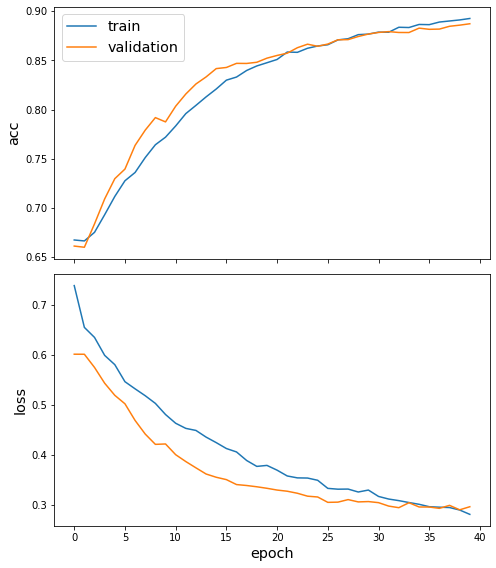

In [120]:
import stellargraph
stellargraph.utils.plot_history(history)

In [121]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


2021-04-21 01:10:53,371 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2021-04-21 01:10:53,372 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


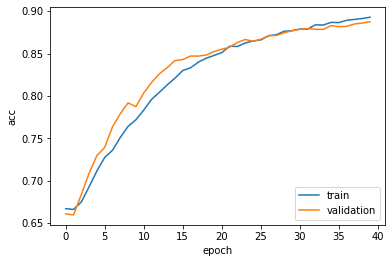

2021-04-21 01:10:53,684 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2021-04-21 01:10:53,685 : WARNING : The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


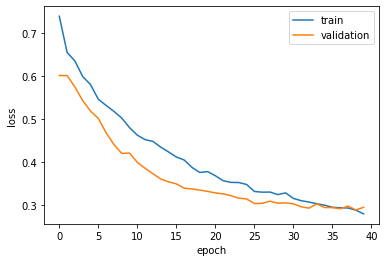

In [122]:
# Plot acc and loss using matplotlib
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig(r'D:\notebooks\lp\small\Mean\plots\accuracy.png', format='png', dpi=300)
plt.savefig(r'D:\notebooks\lp\small\Mean\plots\acc.eps', format='eps', dpi=300)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig(r'D:\notebooks\lp\small\Mean\plots\loss.png', format='png', dpi=300)
plt.savefig(r'D:\notebooks\lp\small\Mean\plots\los.eps', format='eps', dpi=300)
plt.show()

In [123]:
train_metrics = model.evaluate(train_flow)
val_metrics = model.evaluate(val_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1208/1208 [==============================] - 50s 41ms/step - loss: 0.2713 - acc: 0.8928 4s -

Train Set Metrics of the trained model:
	loss: 0.2599
	acc: 0.8987

Validation Set Metrics of the trained model:
	loss: 0.2863
	acc: 0.8880

Test Set Metrics of the trained model:
	loss: 0.2713
	acc: 0.8928


In [124]:
print("test_matrics: ", test_metrics)

test_matrics:  [0.27134642004966736, 0.8928127884864807]


In [125]:
model.save(r'D:\notebooks\lp\small\Mean\model\model')

INFO:tensorflow:Assets written to: D:\notebooks\lp\small\Mean\model\model\assets


2021-04-21 01:13:53,142 : INFO : Assets written to: D:\notebooks\lp\small\Mean\model\model\assets


### The code ahead is to generate a raw csv with probabilities of link predicted. This csv can be further  used to calculate different metrics like acc, precision, recall, AP, auc etc.

In [126]:
y_true = test_flow.targets

In [127]:
y_true

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [128]:
y_pred = model.predict(test_flow, verbose=1)

1208/1208 [==============================] - 50s 41ms/step


In [129]:
y_pred = y_pred[:, 0]

In [130]:
y_pred

array([0.98647267, 0.99999976, 0.643442  , ..., 0.4262353 , 0.5328256 ,
       0.        ], dtype=float32)

In [131]:
data = []
for i in range(len(y_true)):
    data.append([y_true[i], y_pred[i]])

In [132]:
df = pd.DataFrame(data, columns=['y_true', 'y_pred'])

In [133]:
df.head()

,y_true,y_pred
0,1,0.986473
1,1,1.000000
2,1,0.643442
3,1,0.559263
4,1,0.962550


In [134]:
df.to_csv(r"D:\notebooks\lp\small\Mean\raw_data.csv", index=False)